In [1]:
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from data_provider import get_data

In [2]:
dataset = get_data('data/original/results.csv')
dataset.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,away_Long_Shots,away_Aggression,away_Penalties,away_Marking,away_Standing_Tackle,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away
39350,2018-06-04,Italy,Netherlands,1,1,Friendly,Turin,Italy,False,2018,...,79.100000,80.8,84.333333,83.000000,83.4,1.914894,1.00,7,1.530612,1.35
39351,2018-06-04,Serbia,Chile,0,1,Friendly,Graz,Austria,True,2018,...,79.500000,85.0,82.000000,76.333333,80.8,1.574074,1.00,2,1.361111,3.00
39352,2018-06-04,Slovakia,Morocco,1,2,Friendly,Geneva,Switzerland,True,2018,...,75.700000,80.8,79.000000,81.333333,78.4,1.659574,2.00,-1,1.575000,1.00
39353,2018-06-04,Armenia,Moldova,0,0,Friendly,Kematen,Austria,True,2018,...,42.975000,72.2,61.333333,73.333333,73.6,0.486486,1.75,-2,1.250000,1.25
39354,2018-06-04,India,Kenya,3,0,Friendly,Mumbai,India,False,2018,...,46.671429,73.2,57.666667,68.000000,63.2,0.911111,0.00,0,1.870968,0.00


In [3]:
print("Dataset length", dataset.shape[0])
dataset = dataset.dropna()
print("Dataset complete cases length", dataset.shape[0])

Dataset length 39355
Dataset complete cases length 6688


In [4]:
dataset.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year', 'home_elo',
       'away_elo', 'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'away_overall_rating_max', 'away_overall_rating_min',
       'away_overall_rating_avg', 'away_potential_max', 'away_potential_min',
       'aw

In [5]:
dataset["home_win"] = np.sign(dataset["home_score"] - dataset["away_score"])
dataset["elo_diff"] = dataset["home_elo"] - dataset["away_elo"]
dataset["rating_diff"] = dataset["home_overall_rating_avg"] - dataset["away_overall_rating_avg"]
dataset["potential_diff"] = dataset["home_potential_avg"] - dataset["away_potential_avg"]
dataset["height_diff"] = dataset["home_height"] - dataset["away_height"]
dataset["weight_diff"] = dataset["home_weight"] - dataset["away_weight"]
dataset["age_diff"] = dataset["home_age"] - dataset["away_age"]
dataset["weak_foot_diff"] = dataset["home_weak_foot"] - dataset["away_weak_foot"]
dataset["internationl_repuatiotion_diff"] = dataset["home_international_reputation"] - dataset["away_international_reputation"]
dataset["crossing_diff"] = dataset["home_Crossing"] - dataset["away_Crossing"]
dataset["finishing_diff"] = dataset["home_Finishing"] - dataset["away_Finishing"]
dataset["heading_accuracy_diff"] = dataset["home_Heading_Accuracy"] - dataset["away_Heading_Accuracy"]
dataset["short_passing_diff"] = dataset["home_Short_Passing"] - dataset["away_Short_Passing"]
dataset["dribbling_diff"] = dataset["home_Dribbling"] - dataset["away_Dribbling"]
dataset["fk_accuracy_diff"] = dataset["home_FK_Accuracy"] - dataset["away_FK_Accuracy"]
dataset["long_passing_diff"] = dataset["home_Long_Passing"] - dataset["away_Long_Passing"]
dataset["ball_control_diff"] = dataset["home_Ball_Control"] - dataset["away_Ball_Control"]
dataset["acceleration_diff"] = dataset["home_Acceleration"] - dataset["away_Acceleration"]
dataset["sprint_speed_diff"] = dataset["home_Sprint_Speed"] - dataset["away_Sprint_Speed"]
dataset["reactions_diff"] = dataset["home_Reactions"] - dataset["away_Reactions"]
dataset["shot_power_diff"] = dataset["home_Shot_Power"] - dataset["away_Shot_Power"]
dataset["stamina_diff"] = dataset["home_Stamina"] - dataset["away_Stamina"]
dataset["strength_diff"] = dataset["home_Strength"] - dataset["away_Strength"]
dataset["long_shots_diff"] = dataset["home_Long_Shots"] - dataset["away_Long_Shots"]
dataset["aggression_diff"] = dataset["home_Aggression"] - dataset["away_Aggression"]
dataset["penalties_diff"] = dataset["home_Penalties"] - dataset["away_Penalties"]
dataset["marking_diff"] = dataset["home_Marking"] - dataset["away_Marking"]
dataset["standing_tackle_diff"] = dataset["home_Standing_Tackle"] - dataset["away_Standing_Tackle"]

In [6]:
feature_columns = ["elo_diff", "rating_diff", "potential_diff",
                   "height_diff", "weight_diff", "age_diff", "weak_foot_diff",
                   "internationl_repuatiotion_diff", "crossing_diff", "finishing_diff", "heading_accuracy_diff",
                   "short_passing_diff", "dribbling_diff", "fk_accuracy_diff", "long_passing_diff",
                   'ball_control_diff', 'acceleration_diff', 'sprint_speed_diff', "reactions_diff",
                   'shot_power_diff', 'stamina_diff', 'strength_diff', 'long_shots_diff',
                   "aggression_diff", "penalties_diff", "marking_diff", "standing_tackle_diff",
                   "away_goal_mean", "away_goals_with_home", "goal_diff_with_away", "home_goal_mean",
                   "home_goals_with_away"]

wtl_col = "home_win"

In [7]:
no_friendly_or_wc = dataset[(dataset["tournament"] != "Friendly") & (dataset["tournament"] != "FIFA World Cup")]
print("No friendly or WC games length: ", no_friendly_or_wc.shape[0])

X = no_friendly_or_wc[feature_columns]
y = no_friendly_or_wc[wtl_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("No friendly games train set length: ", X_train.shape[0])

friendly_games = dataset[dataset["tournament"] == "Friendly"]
print("Friendly games length: ", friendly_games.shape[0])
X_friendly = friendly_games[feature_columns]
y_friendly = friendly_games[wtl_col]

X_train = pd.concat([X_train, X_friendly])
y_train = pd.concat([y_train, y_friendly])

wc_games = dataset[dataset["tournament"] == "FIFA World Cup"]
print("WC games length: ", wc_games.shape[0])
X_wc = wc_games[feature_columns]
y_wc = wc_games[wtl_col]
X_test = pd.concat([X_test, X_wc])
y_test = pd.concat([y_test, y_wc])

print("Whole train set length: ", X_train.shape[0])
print("Whole test set length: ", X_test.shape[0])
print("Train set width: ", X_train.shape[1])

No friendly or WC games length:  3790
No friendly games train set length:  2842
Friendly games length:  2770
WC games length:  128
Whole train set length:  5612
Whole test set length:  1076
Train set width:  32


In [8]:
no_friendly_or_wc

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,sprint_speed_diff,reactions_diff,shot_power_diff,stamina_diff,strength_diff,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff
28860,2007-01-07,Haiti,Bermuda,2,0,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,True,2007,...,-4.633333,-8.775,13.05,8.100000,11.475000,2.700000,16.650,19.066667,25.200000,11.350000
28864,2007-01-09,Bermuda,Haiti,0,3,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,True,2007,...,4.633333,8.775,-13.05,-8.100000,-11.475000,-2.700000,-16.650,-19.066667,-25.200000,-11.350000
28870,2007-01-12,Trinidad and Tobago,Barbados,1,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,11.666667,16.500,4.20,3.500000,10.000000,2.800000,17.800,14.333333,44.166667,38.400000
28879,2007-01-15,Haiti,Barbados,2,0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,True,2007,...,1.666667,-9.675,-4.05,-14.400000,-0.225000,-5.400000,3.150,4.666667,22.500000,10.450000
28889,2007-01-17,Trinidad and Tobago,Haiti,3,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,10.000000,26.175,8.25,17.900000,10.225000,8.200000,14.650,9.666667,21.666667,27.950000
28907,2007-01-23,Trinidad and Tobago,Haiti,1,2,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,10.000000,26.175,8.25,17.900000,10.225000,8.200000,14.650,9.666667,21.666667,27.950000
28925,2007-02-06,Cyprus,Hungary,2,1,Cyprus International Tournament,Limassol,Cyprus,False,2007,...,-0.666667,-0.600,-5.40,-9.520000,-11.620000,-5.300000,-5.200,2.000000,-6.000000,-16.000000
28928,2007-02-06,Latvia,Bulgaria,0,2,Cyprus International Tournament,Larnaca,Cyprus,True,2007,...,-11.500000,-25.300,-28.70,-15.900000,-30.300000,-14.200000,-25.900,-15.000000,-33.166667,-59.900000
28940,2007-02-07,Cyprus,Bulgaria,0,3,Cyprus International Tournament,Nicosia,Cyprus,False,2007,...,-11.333333,-10.800,-15.40,-13.020000,-13.920000,-16.000000,-14.200,-4.666667,-6.666667,-19.200000
28948,2007-02-07,Latvia,Hungary,0,2,Cyprus International Tournament,Limassol,Cyprus,True,2007,...,-0.833333,-15.100,-18.70,-12.400000,-28.000000,-3.500000,-16.900,-8.333333,-32.500000,-56.700000


<Figure size 1440x432 with 0 Axes>

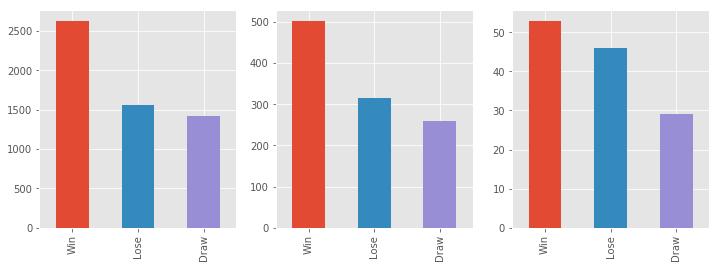

In [9]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

,elo_diff,rating_diff,potential_diff,height_diff,weight_diff,age_diff,weak_foot_diff,internationl_repuatiotion_diff,crossing_diff,finishing_diff,...,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away
elo_diff,1.000000,0.771376,0.766582,0.528574,0.433249,0.444807,0.451110,0.713480,0.696944,0.680038,...,0.697972,0.596008,0.668184,0.581350,0.595689,-0.501468,-0.479422,0.377257,0.501488,0.473649
rating_diff,0.771376,1.000000,0.972442,0.743865,0.627888,0.668642,0.559329,0.770569,0.765848,0.762763,...,0.829209,0.740442,0.748777,0.680080,0.722831,-0.384507,-0.428090,0.350456,0.400533,0.440846
potential_diff,0.766582,0.972442,1.000000,0.755913,0.623026,0.567351,0.551638,0.755221,0.764642,0.756521,...,0.815025,0.732374,0.744147,0.676315,0.721888,-0.373353,-0.424809,0.353445,0.399292,0.446809
height_diff,0.528574,0.743865,0.755913,1.000000,0.894461,0.662681,0.490225,0.473164,0.608946,0.633397,...,0.659562,0.672489,0.615227,0.616499,0.666115,-0.252273,-0.322110,0.216805,0.263038,0.315872
weight_diff,0.433249,0.627888,0.623026,0.894461,1.000000,0.599737,0.362596,0.396319,0.448533,0.515225,...,0.525222,0.589367,0.511600,0.525308,0.567866,-0.211965,-0.269136,0.165221,0.214008,0.246347
age_diff,0.444807,0.668642,0.567351,0.662681,0.599737,1.000000,0.442823,0.458021,0.542652,0.535234,...,0.590409,0.578362,0.536775,0.534684,0.569668,-0.229214,-0.274467,0.178981,0.203363,0.237457
weak_foot_diff,0.451110,0.559329,0.551638,0.490225,0.362596,0.442823,1.000000,0.396658,0.569589,0.548618,...,0.594378,0.443445,0.543678,0.431174,0.467198,-0.258450,-0.261791,0.183590,0.274539,0.250657
internationl_repuatiotion_diff,0.713480,0.770569,0.755221,0.473164,0.396319,0.458021,0.396658,1.000000,0.584629,0.579679,...,0.607438,0.504499,0.568567,0.505830,0.544157,-0.372737,-0.389933,0.375177,0.415243,0.404668
crossing_diff,0.696944,0.765848,0.764642,0.608946,0.448533,0.542652,0.569589,0.584629,1.000000,0.875297,...,0.863154,0.796441,0.843751,0.780126,0.789054,-0.340209,-0.387796,0.301070,0.356048,0.423172
finishing_diff,0.680038,0.762763,0.756521,0.633397,0.515225,0.535234,0.548618,0.579679,0.875297,1.000000,...,0.896355,0.753075,0.874620,0.660355,0.665593,-0.334846,-0.384984,0.288580,0.343538,0.409560


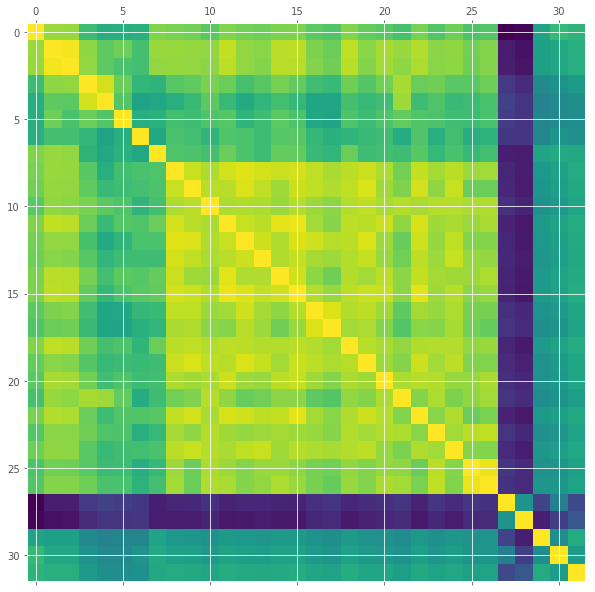

In [10]:
plt.figure(figsize=(10,10))
plt.matshow(X_train.corr(), fignum=1)
X_train.corr()

In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
def get_feature_importance(clf):
    zipped = sorted(zip(feature_columns, clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [13]:
def run_random_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      n_iter_search=60, custom_report_for_model=None, 
                      preprocess=False):
    
    if preprocess:
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)

In [15]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

param_dist = {"n_estimators": [1000],
              "max_depth": [None],
              "min_samples_leaf": [5],
              "max_features": ["sqrt"],
              "criterion": ["gini"]}
run_random_search(clf, param_dist,
                  X_train, y_train, 
                  X_test, y_test, 
                  X_wc, y_wc,
                  custom_report_for_model=get_feature_importance, 
                  preprocess=False, n_iter_search=1)

TRAIN SET METRICS:
SCORE:  0.910192444761
             precision    recall  f1-score   support

         -1       0.92      0.90      0.91      1563
          0       0.99      0.81      0.89      1418
          1       0.87      0.97      0.92      2631

avg / total       0.92      0.91      0.91      5612

BEST PARAMS:  {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


TEST SET METRICS:
SCORE:  0.634758364312

              precision    recall  f1-score   support

         -1       0.61      0.75      0.67       314
          0       0.42      0.10      0.16       259
          1       0.67      0.84      0.75       503

avg / total       0.59      0.63      0.58      1076



WC SET METRICS:
SCORE:  0.6953125

              precision    recall  f1-score   support

         -1       0.78      0.78      0.78        46
          0       0.43      0.10      0.17        29
          1       0.67      0.94      0.78        53

a